https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook  
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf

import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize

%matplotlib inline

import _init_path

In [16]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [1]:
import keras
from keras import backend as K
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
images_path = glob(os.path.join('data', '*_stage1', '*', '*', '*'))

len(images_path)

30196

In [3]:
path_df = pd.DataFrame(index=images_path)

img_type = lambda path: path.split('/')[-2]
img_id = lambda path: path.split('/')[-3]
img_group = lambda path: path.split('/')[-4].split('_')[0]
img_stage =lambda path: path.split('/')[-4].split('_')[1]

path_df['Image_ID'] = path_df.index.map(img_id)
path_df['Image_GROUP'] = path_df.index.map(img_group)
path_df['Image_TYPE'] = path_df.index.map(img_type)
path_df['Image_STAGE'] = path_df.index.map(img_stage)

path_df.head()

,Image_ID,Image_GROUP,Image_TYPE,Image_STAGE
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/235e0f8b86d5c55c4a06824609a73529f635c35662e923125afa6547bb3e94fc.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/f7bcd4e0827008b727de64a8cb8b711c05a60d70ea5ec502750889a4c16ff649.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/11ac8eace5d73fc8054822b46db13e09813527faa13ced27b34438a71ae283fe.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/284555ce90e1a496fa3614caebd5c950e8958bcb6fcba15a3c3348adf6f95a45.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1
data/train_stage1/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks/f3aa2fb4bbf59cadb44b80816e27829d53a42a3070b25344b940d74c7f904081.png,a9d884ba0929dac87c2052ce5b15034163685317d7cff4...,train,masks,stage1


In [4]:
path_df.describe()

,Image_ID,Image_GROUP,Image_TYPE,Image_STAGE
count,30196,30196,30196,30196
unique,735,2,2,1
top,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,train,masks,stage1
freq,376,30131,29461,30196


In [7]:
%%time

train_df = path_df.query('Image_GROUP=="train"')
train_rows = []
group_cols = ['Image_STAGE', 'Image_ID']

for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('Image_TYPE == "masks"').index.values.tolist()
    c_row['images'] = n_rows.query('Image_TYPE == "images"').index.values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

CPU times: user 1.88 s, sys: 20 ms, total: 1.9 s
Wall time: 1.88 s


In [8]:
%%time
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([resize(imread(c_img), (img_height, img_width)) for c_img in in_img_list], 0), 0) # /255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


CPU times: user 2min, sys: 4.78 s, total: 2min 5s
Wall time: 2min 5s


In [9]:
img_height, img_width = 256, 256

In [10]:
train_img_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 4 columns):
Image_ID       670 non-null object
Image_STAGE    670 non-null object
images         670 non-null object
masks          670 non-null object
dtypes: object(4)
memory usage: 335.3 MB


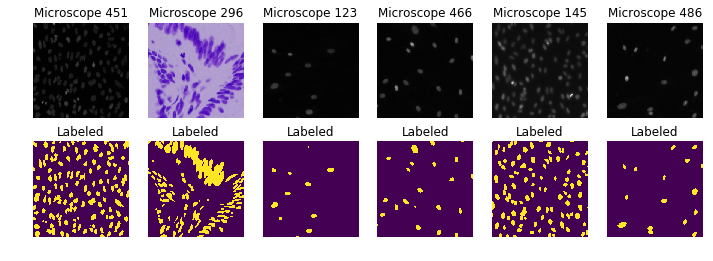

In [11]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope ' + str(_))
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [21]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [22]:
inputs = Input((img_height, img_width, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 128, 32)      0         
__________

In [38]:
def train_gen():
    while True:
        for _, c_row in train_img_df.loc[:599, :].iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)
            
def val_gen():
    while True:
        for _, c_row in train_img_df.loc[600:, :].iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

In [39]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

In [49]:
model.fit_generator(train_gen(), #validation_data=val_gen, validation_steps=20,
                    steps_per_epoch=600, epochs=50, 
                    # callbacks=[earlystopper, checkpointer]
                    )

Epoch 1/50
600/600 [==============================] - 21s - loss: 0.1266 - mean_iou: 0.6706    
Epoch 2/50
600/600 [==============================] - 21s - loss: 0.1248 - mean_iou: 0.6782    
Epoch 3/50
600/600 [==============================] - 21s - loss: 0.1197 - mean_iou: 0.6845    
Epoch 4/50
600/600 [==============================] - 21s - loss: 0.1179 - mean_iou: 0.6899    
Epoch 5/50
600/600 [==============================] - 21s - loss: 0.1151 - mean_iou: 0.6949    
Epoch 6/50
600/600 [==============================] - 22s - loss: 0.1145 - mean_iou: 0.6993    
Epoch 7/50
600/600 [==============================] - 21s - loss: 0.1131 - mean_iou: 0.7033    
Epoch 8/50
600/600 [==============================] - 21s - loss: 0.1120 - mean_iou: 0.7069    
Epoch 9/50
600/600 [==============================] - 21s - loss: 0.1111 - mean_iou: 0.7102    
Epoch 10/50
600/600 [==============================] - 22s - loss: 0.1099 - mean_iou: 0.7133    
Epoch 11/50
600/600 [==================

KeyboardInterrupt: 

In [66]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [67]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[mean_iou])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 128, 32)      0         
__________

In [68]:
model.fit_generator(train_gen(), #validation_data=val_gen, validation_steps=20,
                    steps_per_epoch=600, epochs=50, 
                    # callbacks=[earlystopper, checkpointer]
                    )

Epoch 1/50
600/600 [==============================] - 20s - loss: -0.8344 - mean_iou: 0.8307    
Epoch 2/50
600/600 [==============================] - 20s - loss: -0.8437 - mean_iou: 0.8400    
Epoch 3/50
600/600 [==============================] - 20s - loss: -0.8469 - mean_iou: 0.8418    
Epoch 4/50
600/600 [==============================] - 20s - loss: -0.8487 - mean_iou: 0.8429    
Epoch 5/50
600/600 [==============================] - 20s - loss: -0.8502 - mean_iou: 0.8437    
Epoch 6/50
600/600 [==============================] - 20s - loss: -0.8512 - mean_iou: 0.8443    
Epoch 7/50
600/600 [==============================] - 20s - loss: -0.8519 - mean_iou: 0.8448    
Epoch 8/50
600/600 [==============================] - 20s - loss: -0.8528 - mean_iou: 0.8452    
Epoch 9/50
600/600 [==============================] - 20s - loss: -0.8533 - mean_iou: 0.8456    
Epoch 10/50
600/600 [==============================] - 20s - loss: -0.8541 - mean_iou: 0.8459    
Epoch 11/50
600/600 [========

KeyboardInterrupt: 

In [ ]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [137]:
simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 10)

Epoch 1/10
670/670 [==============================] - 41s - loss: -0.7410 - dice_coef: 0.7410 - acc: 0.9033 - mean_squared_error: 0.0932    
Epoch 2/10
670/670 [==============================] - 36s - loss: -0.7960 - dice_coef: 0.7960 - acc: 0.9288 - mean_squared_error: 0.0701    
Epoch 3/10
670/670 [==============================] - 38s - loss: -0.8016 - dice_coef: 0.8016 - acc: 0.9307 - mean_squared_error: 0.0687    
Epoch 4/10
670/670 [==============================] - 37s - loss: -0.8037 - dice_coef: 0.8037 - acc: 0.9310 - mean_squared_error: 0.0687    
Epoch 5/10
670/670 [==============================] - 38s - loss: -0.7979 - dice_coef: 0.7979 - acc: 0.9305 - mean_squared_error: 0.0693    
Epoch 6/10
670/670 [==============================] - 38s - loss: -0.7980 - dice_coef: 0.7980 - acc: 0.9253 - mean_squared_error: 0.0745    
Epoch 7/10
670/670 [==============================] - 38s - loss: -0.7977 - dice_coef: 0.7977 - acc: 0.9278 - mean_squared_error: 0.0721    
Epoch 8/10
67

In [136]:
%%time
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([resize(imread(c_img), (img_height, img_width)) for c_img in in_img_list], 0), 0) # /255.0

def read_and_save_shape(in_img):
    return imread(in_img[0]).shape[:2] # /255.0


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 41.5 µs


In [137]:
%%time
test_df = path_df.query('Image_GROUP=="test"')
test_rows = []
group_cols = ['Image_STAGE', 'Image_ID']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('Image_TYPE == "images"').index.values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['shape'] = test_img_df['images'].map(read_and_save_shape)
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])

print(test_img_df.shape[0], 'images to process')

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


65 images to process
CPU times: user 1.76 s, sys: 416 ms, total: 2.18 s
Wall time: 2.1 s


In [138]:
test_img_df.head(5)

,Image_ID,Image_STAGE,images,shape
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,stage1,"[[[0.0117647058824, 0.0117647058824, 0.0117647...","(256, 256)"
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,stage1,"[[[0.0759692173378, 0.0759692173378, 0.0759692...","(519, 253)"
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,stage1,"[[[0.0705882352941, 0.0705882352941, 0.0705882...","(256, 256)"
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,stage1,"[[[0.0509803921569, 0.0509803921569, 0.0509803...","(256, 256)"
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,stage1,"[[[0.0549019607843, 0.0549019607843, 0.0549019...","(256, 256)"


In [141]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: model.predict(np.expand_dims(x, 0))[0, :, :, 0])

CPU times: user 532 ms, sys: 44 ms, total: 576 ms
Wall time: 444 ms


In [146]:
count = 0
for _ in range(test_img_df.shape[0]):
    if test_img_df.loc[_, 'shape'] == (256, 256):
        pass
    else:
        # print(_)
        count += 1
        test_img_df.loc[_, 'masks'] = resize(test_img_df.loc[_, 'masks'], test_img_df.loc[_, 'shape'])
        
print(count)

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


41


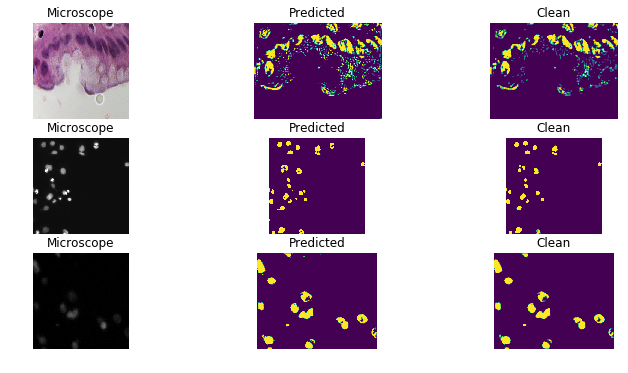

In [149]:
n_img = 3
from skimage.morphology import closing, opening, disk

def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

In [54]:
train_labels = pd.read_csv('data/train_stage1_labels/stage1_train_labels.csv')
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
353,03b9306f44e9b8951461623dcbd615550cdcf36ea93b20...,"[106895, 2, 107242, 22, 107600, 26, 107957, 35..."
21460,b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d...,"[92249, 12, 92607, 18, 92962, 24, 93321, 31, 9..."
5446,2b50b1e3fa5c5aa39bc84ebfaea9961b7199c4d2488ae0...,"[1843, 6, 2097, 10, 2352, 12, 2607, 14, 2862, ..."


In [150]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [151]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

In [152]:
tl_rles = train_labels.query('ImageId=="{Image_ID}"'.format(**train_rle_row))['EncodedPixels']

In [153]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 124, Mismatches: 214, Accuracy: 36.7%


In [154]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [155]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['Image_ID'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

2780 regions found for 65 images


,EncodedPixels,ImageId
527,340262 2 340772 6 341283 8 341795 8 342306 10 ...,259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67...
1350,20124 10 20642 14 21161 16 21680 18 22199 20 2...,550450e4bff4036fd671decdc5d42fec23578198d6a2fd...
1702,35450 3 35704 7 35958 11 36213 14 36469 15 367...,7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4...


In [156]:
out_pred_df.head(1)

,EncodedPixels,ImageId
0,45106 5 45360 9 45614 11 45870 12 46125 12 463...,0114f484a16c152baa2d82fdd43740880a762c93f436c8...


In [157]:
out_pred_df[['ImageId', 'EncodedPixels']].head(1)

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45106 5 45360 9 45614 11 45870 12 46125 12 463...


In [158]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)

In [160]:
import keras

In [161]:
keras.__version__

'2.0.3'

In [173]:
""" setup python path """
import os.path as osp
import sys

In [179]:
os.getcwd()

'/home/liushrui/code/dsb2018'

In [ ]:
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

lib_path = osp.join(osp.dirname(__file__), '..', '..', 'lib')
add_path(lib_path)

In [176]:
os.path

<module 'posixpath' from '/home/liushrui/install/anaconda3/lib/python3.5/posixpath.py'>

In [175]:
osp

<module 'posixpath' from '/home/liushrui/install/anaconda3/lib/python3.5/posixpath.py'>